# Predicting diabetes risk

Diabetes is an extremely common chronic disease in the United States. It's also extremely taxing on the people who have it, both physically as well as economically. Given this, it might be worth exploring whether the risk of diabetes can be predicted with data. To explore the risk factors for diabetes, I will use the Behavioral Risk Factor Surveillance System (BRFSS) from 2015. This dataset can be found on [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv): 



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor


2023-07-20 17:52:44.222342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

As a crude first pass, since I am dealing with ordinal and binary data, I can look at how they are related using a Spearman correlation.

<Axes: >

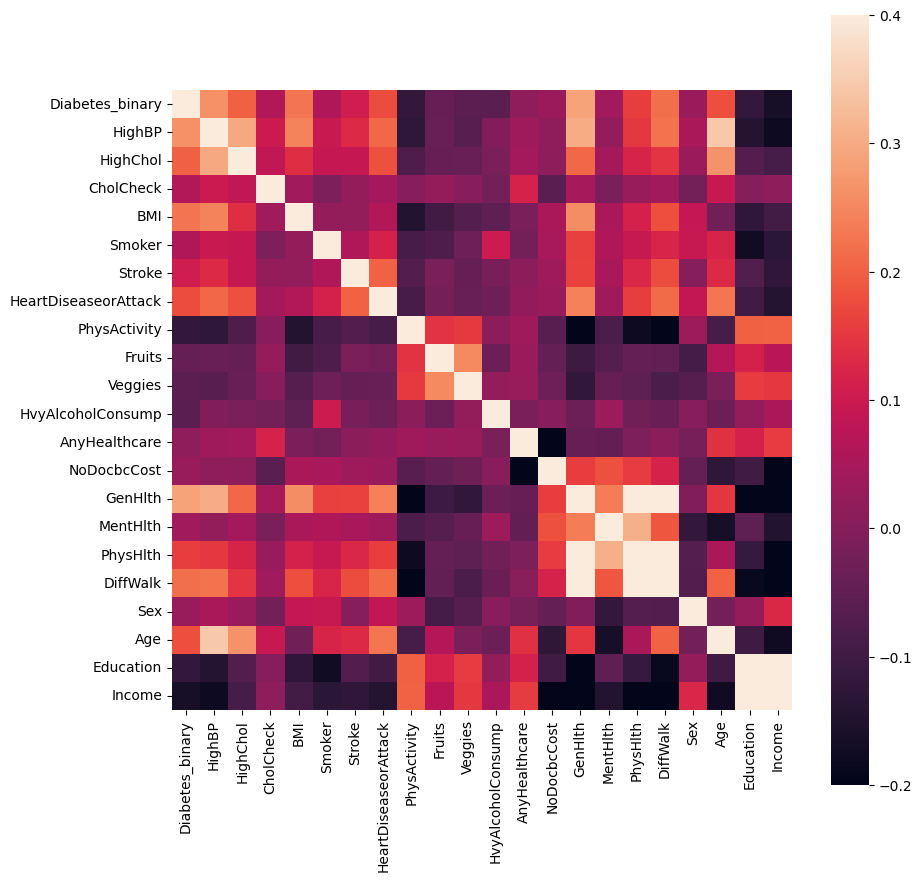

In [3]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(method='spearman'),vmin = -0.2, vmax = 0.4, square=True)

In [17]:
X = data.drop(['Diabetes_binary'],axis=1)
y = data['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)

In [29]:
from imblearn.over_sampling import SMOTE

In [105]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_sc,y_train)


In [106]:
print('Original dataset %s' % Counter(y_train))
print('Resampled dataset %s' % Counter(y_train_res))

Original dataset Counter({0.0: 174713, 1.0: 28231})
Resampled dataset Counter({1.0: 174713, 0.0: 174713})


I used SMOTE to oversample the original training set, which had much fewer 1's than 0's

In [81]:
tuner_os = BayesianOptimization(
    build_model,
    objective = "val_loss",
    max_trials = 10,
    executions_per_trial = 1,
    directory = "diabetes_risk",
    overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [83]:
tuner_os.search(x=X_train_res,y=y_train_res,epochs=40,batch_size=1024,validation_split=0.2,callbacks=[stop_early])

Trial 10 Complete [00h 01m 16s]
val_loss: 0.15983586013317108

Best val_loss So Far: 0.12180133163928986
Total elapsed time: 00h 20m 36s
INFO:tensorflow:Oracle triggered exit


In [90]:
print(tuner_os.get_best_hyperparameters()[0].values)
best_model_os = tuner_os.get_best_models()[0]
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = best_model_os.fit(X_train_res, y_train_res, validation_split = 0.33,epochs=400, batch_size = 2048,callbacks=[stop_early])

{'input_units': 416, 'n_layers': 3, 'layer_0': 256, 'layer_1': 384, 'layer_2': 384}
Epoch 1/400
115/115 [==============================] - 6s 46ms/step - loss: 0.0802 - accuracy: 0.8913 - val_loss: 0.1703 - val_accuracy: 0.7616
Epoch 2/400
115/115 [==============================] - 5s 43ms/step - loss: 0.0762 - accuracy: 0.8973 - val_loss: 0.1454 - val_accuracy: 0.8062
Epoch 3/400
115/115 [==============================] - 5s 43ms/step - loss: 0.0742 - accuracy: 0.9005 - val_loss: 0.1615 - val_accuracy: 0.7799
Epoch 4/400
115/115 [==============================] - 5s 42ms/step - loss: 0.0726 - accuracy: 0.9029 - val_loss: 0.1582 - val_accuracy: 0.7839
Epoch 5/400
115/115 [==============================] - 5s 46ms/step - loss: 0.0717 - accuracy: 0.9042 - val_loss: 0.1625 - val_accuracy: 0.7775
Epoch 6/400
115/115 [==============================] - 5s 46ms/step - loss: 0.0700 - accuracy: 0.9068 - val_loss: 0.1650 - val_accuracy: 0.7776
Epoch 7/400
115/115 [==============================]

Text(0.5, 0, 'Epochs')

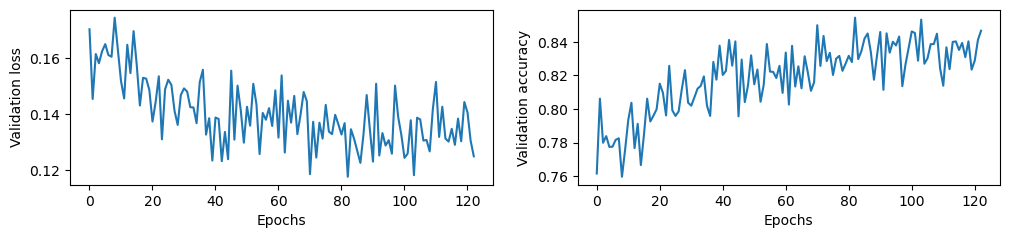

In [91]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

1586/1586 [==============================] - 2s 1ms/step
[[0.76194418 0.09782009]
 [0.09334595 0.04688978]]


Text(50.722222222222214, 0.5, 'Actual')

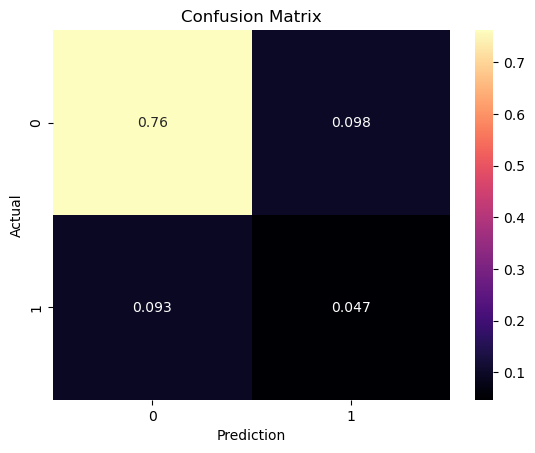

In [92]:
y_pred = best_model_os.predict(X_test_sc)
conf_mat = metrics.confusion_matrix(y_test,np.round(y_pred))
conf_mat = conf_mat/np.sum(conf_mat)
print(conf_mat)
sns.heatmap(conf_mat,annot=True,cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [102]:
test_loss, test_acc = best_model_os.evaluate(X_test_sc, y_test)
print("Loss: %s" % test_loss)
print("Accuracy: %s" % test_acc)

1586/1586 [==============================] - 2s 1ms/step - loss: 0.1706 - accuracy: 0.8088
Loss: 0.1705981194972992
Accuracy: 0.8088339567184448
